In [ ]:
!wget https://phm-datasets.s3.amazonaws.com/NASA/4.+Bearings.zip

--2025-07-25 10:18:54--  https://phm-datasets.s3.amazonaws.com/NASA/4.+Bearings.zip
Resolving phm-datasets.s3.amazonaws.com (phm-datasets.s3.amazonaws.com)... 3.5.27.250, 52.216.49.17, 3.5.27.67, ...
Connecting to phm-datasets.s3.amazonaws.com (phm-datasets.s3.amazonaws.com)|3.5.27.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1075597174 (1.0G) [application/zip]
Saving to: ‘4.+Bearings.zip’

4.+Bearings.zip     100%[===================>]   1.00G  56.1MB/s    in 20s     

2025-07-25 10:19:15 (51.5 MB/s) - ‘4.+Bearings.zip’ saved [1075597174/1075597174]



In [ ]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.9/412.9 kB 23.2 MB/s eta 0:00:00


In [ ]:
!unzip "/content/4.+Bearings.zip"

Archive:  /content/4.+Bearings.zip
   creating: 4. Bearings/
  inflating: 4. Bearings/IMS.7z      


In [ ]:
import os
os.listdir()

['.config', '4. Bearings', '4.+Bearings.zip', 'sample_data']

In [ ]:
import py7zr
archive_path = "/content/4. Bearings/IMS.7z"
extract_path = "/content/4. Bearings/"

# Extract the .7z file
with py7zr.SevenZipFile(archive_path, mode='r') as archive:
    archive.extractall(path=extract_path)

In [ ]:
!apt-get install -y unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
!pip install patool
import patoolib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 3.3 MB/s eta 0:00:00


In [ ]:
patoolib.extract_archive("/content/4. Bearings/2nd_test.rar", outdir="/content/")

INFO patool: Extracting /content/4. Bearings/2nd_test.rar ...
INFO:patool:Extracting /content/4. Bearings/2nd_test.rar ...
INFO patool: running /usr/bin/unrar x -kb -or -- "/content/4. Bearings/2nd_test.rar"
INFO:patool:running /usr/bin/unrar x -kb -or -- "/content/4. Bearings/2nd_test.rar"
INFO patool: ... /content/4. Bearings/2nd_test.rar extracted to `/content/'.
INFO:patool:... /content/4. Bearings/2nd_test.rar extracted to `/content/'.


'/content/'

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft
import statsmodels.api as sm
import numba

def compute_statistical_features(signal):
    rms = np.sqrt(np.mean(signal**2))
    skewness = skew(signal)
    kurt = kurtosis(signal)
    crest_factor = np.max(np.abs(signal)) / rms
    shape_factor = rms / np.mean(np.abs(signal))
    impulse_factor = np.max(np.abs(signal)) / np.mean(np.abs(signal))
    clearance_factor = np.max(np.abs(signal)) / (np.mean(np.sqrt(np.abs(signal)))**2)
    #imfs = EMD().emd(signal)
   # selected_imf = imfs[1]
    #ar_params = sm.regression.yule_walker(signal, order=5, method="mle")[0]
    #ar_mean = np.mean(ar_params)
    #ar_params = ar_params[np.argmax(np.abs(ar_params))]
   # ar_params= 1 / (1 + np.exp(-ar_params[4]))  #sigmoid
    return [rms, skewness, kurt, crest_factor, shape_factor, impulse_factor, clearance_factor]

def compute_frequency_features(signal, sampling_rate=20480):
    signal = signal - np.mean(signal)  # Remove DC component
    N = len(signal)  # Number of points
    fft_values = fft(signal)[:N//2]
    amplitudes = np.abs(fft_values) / N
    frequencies = np.linspace(0, sampling_rate / 2, N//2)  # Frequency axis

    # Extract meaningful frequency features
    dominant_freq = frequencies[np.argmax(amplitudes)]
    mean_freq = np.sum(frequencies * amplitudes) / np.sum(amplitudes)
    median_freq = frequencies[np.searchsorted(np.cumsum(amplitudes), np.sum(amplitudes) / 2)]

    return [dominant_freq, mean_freq, median_freq]
data_dir = '/content/2nd_test'

# Initialize DataFrame
df = pd.DataFrame()

# Process each file
for filename in os.listdir(data_dir):
    file_path = os.path.join(data_dir, filename)
    dataset = pd.read_csv(file_path, sep='\t', header=None)
    signal = dataset.iloc[:,0].values

    # Compute features
    stat_features = compute_statistical_features(signal)
    freq_features = compute_frequency_features(signal, sampling_rate=20480)

    # Combine all features
    all_features = stat_features + freq_features

    # Create DataFrame for the current file
    feature_df = pd.DataFrame([all_features], columns=[
        "RMS", "Skewness", "Kurtosis", "Crest Factor",
        "Shape Factor", "Impulse Factor", "Clearance Factor",
        "Dominant Frequency", "Mean Frequency", "Median Frequency"
    ])
    timestamp = pd.to_datetime(filename, format='%Y.%m.%d.%H.%M.%S')
    feature_df.index = [timestamp]

    df = pd.concat([df, feature_df])
df = df.sort_index()
(df.head())

,RMS,Skewness,Kurtosis,Crest Factor,Shape Factor,Impulse Factor,Clearance Factor,Dominant Frequency,Mean Frequency,Median Frequency
2004-02-12 10:32:39,0.074179,0.083993,0.628763,6.120331,1.271660,7.782979,9.258404,1009.098545,4172.054881,4074.397890
2004-02-12 10:42:39,0.075382,0.052142,0.648291,5.147086,1.277742,6.576647,7.834513,1009.098545,4196.970406,4094.399844
2004-02-12 10:52:39,0.076230,0.032808,0.513475,6.598472,1.265456,8.350077,9.907938,1009.098545,4149.106510,4052.395742
2004-02-12 11:02:39,0.078724,0.041486,1.157953,7.723217,1.281033,9.893696,11.794197,1009.098545,4124.423911,4010.391640
2004-02-12 11:12:39,0.078474,0.028224,0.603177,4.982524,1.278896,6.372127,7.622802,1009.098545,4140.684367,4053.395839


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

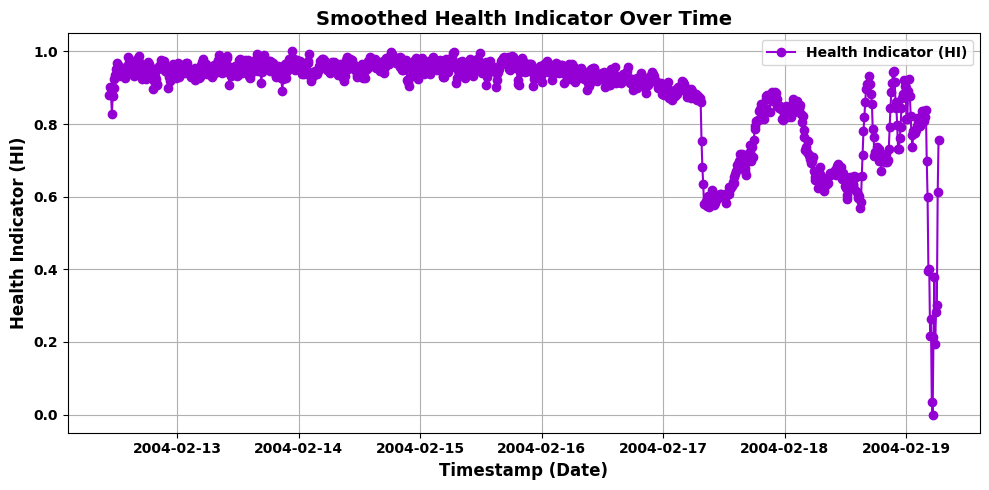

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def health(data, use_filter=True):
    bearing_data = data.copy()

    # Step 1: Extract only feature columns (ignore datetime index)
    feature_columns = ['RMS', 'Skewness', 'Kurtosis', 'Crest Factor',
                       'Shape Factor', 'Impulse Factor', 'Clearance Factor',
                       'Dominant Frequency', 'Mean Frequency', 'Median Frequency']

    feature_data = bearing_data[feature_columns]  # Extract vibration features

    # Step 2: Standardize features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(feature_data)

    # Step 3: Apply PCA (Extract First Principal Component)
    pca = PCA(n_components=1)
    health_indicator = pca.fit_transform(data_scaled).flatten()

    # Step 4: Smooth HI using EWMA (to prevent sudden drops)
    if use_filter:
        health_indicator = pd.Series(health_indicator).ewm(span=4, adjust=False).mean().values

    # Step 5: Normalize HI so that it starts at 1 and degrades to 0
    health_indicator = (health_indicator - np.min(health_indicator)) / (np.max(health_indicator) - np.min(health_indicator))
    health_indicator = 1 - health_indicator  # Ensure HI starts at 1 and degrades smoothly

    # Step 6: Store HI as a new column in the original DataFrame
    bearing_data['label'] = health_indicator

    return bearing_data  # Returns dataframe with HI column added

df_with_HI = health(df)


plt.figure(figsize=(10, 5))
plt.plot(df_with_HI.index, df_with_HI['label'], marker='o', linestyle='-', color='darkviolet', label="Health Indicator (HI)")

# Bold title
plt.title("Smoothed Health Indicator Over Time", fontsize=14, fontweight='bold')

# Bold axis labels
plt.xlabel("Timestamp (Date)", fontsize=12, fontweight='bold')
plt.ylabel("Health Indicator (HI)", fontsize=12, fontweight='bold')

# Bold tick labels
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

# Bold legend
plt.legend(fontsize=12, prop={'weight': 'bold'})

# Grid and layout
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#df_with_HI.head()
df=df_with_HI
df.head()

,RMS,Skewness,Kurtosis,Crest Factor,Shape Factor,Impulse Factor,Clearance Factor,Dominant Frequency,Mean Frequency,Median Frequency,label
2004-02-12 10:32:39,0.074179,0.083993,0.628763,6.120331,1.271660,7.782979,9.258404,1009.098545,4172.054881,4074.397890,0.880403
2004-02-12 10:42:39,0.075382,0.052142,0.648291,5.147086,1.277742,6.576647,7.834513,1009.098545,4196.970406,4094.399844,0.901342
2004-02-12 10:52:39,0.076230,0.032808,0.513475,6.598472,1.265456,8.350077,9.907938,1009.098545,4149.106510,4052.395742,0.880468
2004-02-12 11:02:39,0.078724,0.041486,1.157953,7.723217,1.281033,9.893696,11.794197,1009.098545,4124.423911,4010.391640,0.827551
2004-02-12 11:12:39,0.078474,0.028224,0.603177,4.982524,1.278896,6.372127,7.622802,1009.098545,4140.684367,4053.395839,0.878007


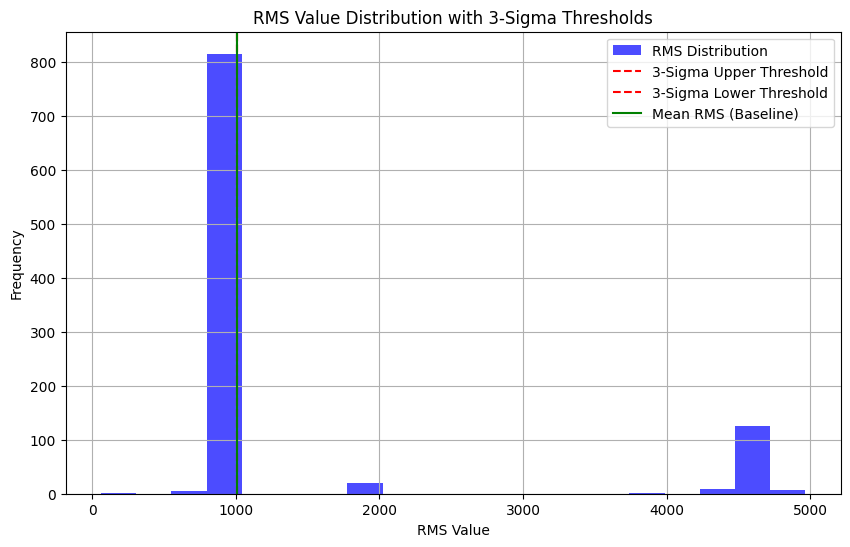

In [ ]:
### Can ignore for now
import matplotlib.pyplot as plt
rms_values=np.asarray(df['Dominant Frequency'])
baseline_rms = rms_values[:max(1, int(len(rms_values) * 0.05))]
baseline_mean = np.mean(baseline_rms)
baseline_std = np.std(baseline_rms)

# Calculate 3-sigma thresholds
upper_threshold = baseline_mean + 3 * baseline_std
lower_threshold = baseline_mean - 3 * baseline_std
plt.figure(figsize=(10, 6))
plt.hist(rms_values, bins=20, color='blue', alpha=0.7, label='RMS Distribution')
plt.axvline(upper_threshold, color='red', linestyle='--', label='3-Sigma Upper Threshold')
plt.axvline(lower_threshold, color='red', linestyle='--', label='3-Sigma Lower Threshold')
plt.axvline(baseline_mean, color='green', linestyle='-', label='Mean RMS (Baseline)')
plt.xlabel('RMS Value')
plt.ylabel('Frequency')
plt.title('RMS Value Distribution with 3-Sigma Thresholds')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#time_values=np.asarray(df['file'])
fpt_index = next((i for i, rms in enumerate(rms_values) if rms > upper_threshold), None)
fpt_time = fpt_index if fpt_index is not None else None
fpt_time

671

In [ ]:
def normaliser(signal):
    signal_mean = np.mean(signal)
    signal_std = np.std(signal)
    return (signal - signal_mean) / signal_std
for col in df.columns:
    if col != 'label':
        df[col] = normaliser(np.asarray(df[col]))
df.head()

,RMS,Skewness,Kurtosis,Crest Factor,Shape Factor,Impulse Factor,Clearance Factor,Dominant Frequency,Mean Frequency,Median Frequency,label
2004-02-12 10:32:39,-0.548710,1.316155,-0.205508,1.643400,-0.517312,1.278902,1.080664,-0.419111,0.189878,-0.296452,0.880403
2004-02-12 10:42:39,-0.528030,0.958207,-0.185277,-0.046506,-0.390162,-0.160796,-0.231495,-0.419111,0.464542,-0.159680,0.901342
2004-02-12 10:52:39,-0.513470,0.740932,-0.324940,2.473626,-0.647008,1.955706,1.679229,-0.419111,-0.063101,-0.446903,0.880468
2004-02-12 11:02:39,-0.470615,0.838455,0.342708,4.426592,-0.321350,3.797939,3.417475,-0.419111,-0.335197,-0.734126,0.827551
2004-02-12 11:12:39,-0.474901,0.689416,-0.232013,-0.332247,-0.366040,-0.404880,-0.426594,-0.419111,-0.155945,-0.440064,0.878007


In [ ]:
features = np.stack((df['RMS'],df['Skewness'],df['Kurtosis'],df['Crest Factor'],df['Shape Factor'],df['Impulse Factor'],df['Clearance Factor'],df['Dominant Frequency'],df['Mean Frequency'],df['Median Frequency']), axis=1)
X=features
y=np.asarray(df['label'])
print(f"LSTM Input Shape (X): {X.shape}")
print(f"RUL Labels Shape (y): {y.shape}")

LSTM Input Shape (X): (984, 10)
RUL Labels Shape (y): (984,)


In [ ]:
# Define sequence length (number of timesteps)
import numba
sequence_length = 3
@numba.jit(nopython=True)
def prepare_sequential_data(X, y, sequence_length):
    X_seq = np.empty((len(X) - sequence_length, sequence_length, X.shape[1]), dtype=X.dtype)
    y_seq = np.empty(len(X) - sequence_length, dtype=y.dtype)

    for i in range(len(X) - sequence_length):
        X_seq[i] = X[i:i + sequence_length]
        y_seq[i] = y[i + sequence_length - 1]
    return X_seq, y_seq
# Example Usage:
X_seq, y_seq = prepare_sequential_data(X, y, sequence_length)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X=torch.Tensor(X_seq)
y=torch.Tensor(y_seq)

# Create a TensorDataset
dataset = TensorDataset(X, y)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, drop_last=False,shuffle=False)

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
import torch
import torch.nn as nn
import torch.autograd as ag

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    """ Self-Attention Mechanism to improve feature selection from LSTM outputs """
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.score = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, lstm_out):
        attn_weights = F.softmax(self.score(torch.tanh(self.attn(lstm_out))), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        return context, attn_weights

class OptimizedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(OptimizedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Bi-directional LSTM with increased dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True,
                            bidirectional=True, dropout=0.4)

        # Attention layer
        self.attention = Attention(hidden_size * 2)

        # Fully connected layers with Swish activation and increased neurons
        self.fc1 = nn.Linear(hidden_size * 2, 256)
        self.swish1 = nn.SiLU()  # Swish Activation
        self.drop1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(256, 128)
        self.swish2 = nn.SiLU()
        self.drop2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # LSTM Forward Pass
        attn_out, attn_weights = self.attention(lstm_out)  # Apply Attention

        # Fully connected layers
        out = self.fc1(attn_out)
        out = self.swish1(out)
        out = self.drop1(out)

        out = self.fc2(out)
        out = self.swish2(out)
        out = self.drop2(out)

        out = self.fc3(out)

        return out

In [ ]:
mse_loss = nn.MSELoss()
model = OptimizedLSTM(input_size=10, hidden_size=128, num_layers=2, output_size=1)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-6)  # AdamW with weight decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [ ]:
a = 0.01  # Degradation coefficient
lambda_phys = 1.0  # Weight for physics loss
num_epochs = 30
model.to(device)

loss=[]

for epoch in range(num_epochs):
    epoch_loss = 0

    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # Zero gradients per batch

        # Ensure data is part of computation graph
        data.requires_grad_(True)

        # Forward pass with CuDNN disabled
        with torch.backends.cudnn.flags(enabled=False):
            H_pred = model(data)

        # Compute Data Loss (MSE between predicted H and true H)
        loss_data = mse_loss(H_pred, target.unsqueeze(1))

        # Compute dH/dt using autograd w.r.t. data (or time)
        dH_dt = torch.autograd.grad(
            outputs=H_pred,
            inputs=data,
            grad_outputs=torch.ones_like(H_pred),
            create_graph=True,
            retain_graph=True,
            allow_unused=True
        )[0]

        if dH_dt is None:
            print("Warning: dH_dt is None! Check if data is in the computation graph.")
            loss_phys = torch.tensor(0.0).to(H_pred.device)
        else:
            # Enforce physics-based degradation model: dH/dt = -a * H
            loss_phys=torch.mean(dH_dt)+a*torch.exp(torch.mean(data))  # Squared loss

        # Total loss = Data loss + Physics-informed loss
        total_loss = loss_data + (loss_phys**2)

        # Backpropagation
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()

    epoch_loss /= len(trainloader)  # Average loss over batches
    loss.append(epoch_loss)

    # Logging
    print(f"Epoch {epoch + 1}: Total Loss = {epoch_loss:.6f}")

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1: Total Loss = 0.728489
Epoch 2: Total Loss = 0.714556
Epoch 3: Total Loss = 0.700682
Epoch 4: Total Loss = 0.685391
Epoch 5: Total Loss = 0.669237
Epoch 6: Total Loss = 0.652669
Epoch 7: Total Loss = 0.633693
Epoch 8: Total Loss = 0.614628
Epoch 9: Total Loss = 0.592950
Epoch 10: Total Loss = 0.568633
Epoch 11: Total Loss = 0.538253
Epoch 12: Total Loss = 0.506020
Epoch 13: Total Loss = 0.468885
Epoch 14: Total Loss = 0.427498
Epoch 15: Total Loss = 0.381315
Epoch 16: Total Loss = 0.330992
Epoch 17: Total Loss = 0.276442
Epoch 18: Total Loss = 0.221420
Epoch 19: Total Loss = 0.168299
Epoch 20: Total Loss = 0.115902
Epoch 21: Total Loss = 0.074250
Epoch 22: Total Loss = 0.045355
Epoch 23: Total Loss = 0.023859
Epoch 24: Total Loss = 0.014226
Epoch 25: Total Loss = 0.011238
Epoch 26: Total Loss = 0.009065
Epoch 27: Total Loss = 0.008501
Epoch 28: Total Loss = 0.007922
Epoch 29: Total Loss = 0.008442
Epoch 30: Total Loss = 0.007984


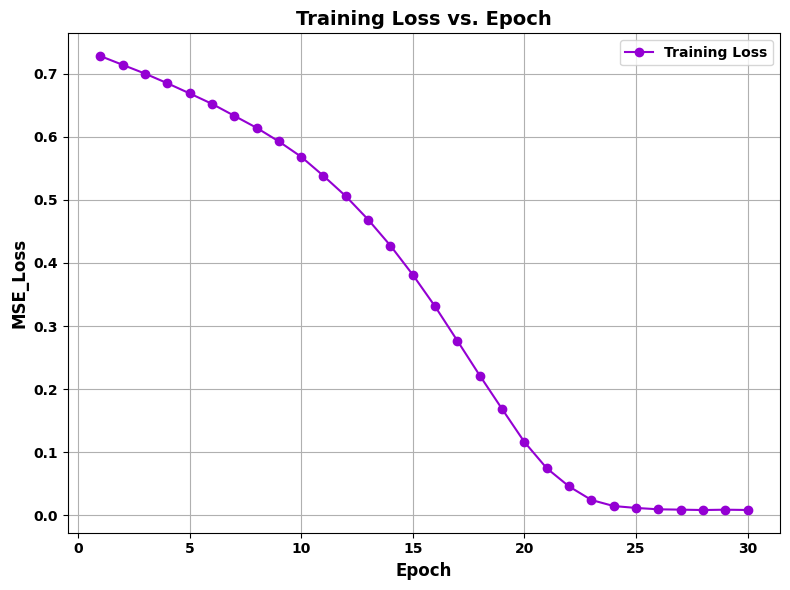

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss vs. Epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, 31), loss, marker='o', linestyle='-', color='darkviolet', label='Training Loss')

# Labels and title with bold text
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('MSE_Loss', fontsize=12, fontweight='bold')
plt.title('Training Loss vs. Epoch', fontsize=14, fontweight='bold')

# Bold tick labels
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

# Grid, legend, and layout
plt.grid(True)
plt.legend(fontsize=12, prop={'weight': 'bold'})
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
patoolib.extract_archive("/content/4. Bearings/1st_test.rar", outdir="/content/")

INFO patool: Extracting /content/4. Bearings/1st_test.rar ...
INFO:patool:Extracting /content/4. Bearings/1st_test.rar ...
INFO patool: running /usr/bin/unrar x -kb -or -- "/content/4. Bearings/1st_test.rar"
INFO:patool:running /usr/bin/unrar x -kb -or -- "/content/4. Bearings/1st_test.rar"
INFO patool: ... /content/4. Bearings/1st_test.rar extracted to `/content/'.
INFO:patool:... /content/4. Bearings/1st_test.rar extracted to `/content/'.


'/content/'

In [ ]:
patoolib.extract_archive("/content/4. Bearings/3rd_test.rar", outdir="/content/")

INFO patool: Extracting /content/4. Bearings/3rd_test.rar ...
INFO:patool:Extracting /content/4. Bearings/3rd_test.rar ...
INFO patool: running /usr/bin/unrar x -kb -or -- "/content/4. Bearings/3rd_test.rar"
INFO:patool:running /usr/bin/unrar x -kb -or -- "/content/4. Bearings/3rd_test.rar"
INFO patool: ... /content/4. Bearings/3rd_test.rar extracted to `/content/'.
INFO:patool:... /content/4. Bearings/3rd_test.rar extracted to `/content/'.


'/content/'

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft

def compute_statistical_features(signal):
    rms = np.sqrt(np.mean(signal**2))
    skewness = skew(signal)
    kurt = kurtosis(signal)
    crest_factor = np.max(np.abs(signal)) / rms
    shape_factor = rms / np.mean(np.abs(signal))
    impulse_factor = np.max(np.abs(signal)) / np.mean(np.abs(signal))
    clearance_factor = np.max(np.abs(signal)) / (np.mean(np.sqrt(np.abs(signal)))**2)
    return [rms, skewness, kurt, crest_factor, shape_factor, impulse_factor, clearance_factor]

def compute_frequency_features(signal, sampling_rate=20480):
    signal = signal - np.mean(signal)  # Remove DC component
    N = len(signal)  # Number of points
    fft_values = fft(signal)[:N//2]
    amplitudes = np.abs(fft_values) / N
    frequencies = np.linspace(0, sampling_rate / 2, N//2)

    # Extract meaningful frequency features
    dominant_freq = frequencies[np.argmax(amplitudes)]
    mean_freq = np.sum(frequencies * amplitudes) / np.sum(amplitudes)
    median_freq = frequencies[np.searchsorted(np.cumsum(amplitudes), np.sum(amplitudes) / 2)]

    return [dominant_freq, mean_freq, median_freq]
data_dir = '/content/4th_test/txt'

# Initialize DataFrame
df = pd.DataFrame()
counter =0
# Process each file
for filename in os.listdir(data_dir):
    #if(counter==4448):
     #   break
    file_path = os.path.join(data_dir, filename)
    dataset = pd.read_csv(file_path, sep='\t', header=None)
    #signal = dataset.iloc[:, [6,7]].mean(axis=1).values
    signal=dataset.iloc[:,2].values
    counter+=1

    # Compute features
    stat_features = compute_statistical_features(signal)
    freq_features = compute_frequency_features(signal, sampling_rate=20480)

    # Combine all features
    all_features = stat_features + freq_features

    # Create DataFrame for the current file
    feature_df = pd.DataFrame([all_features], columns=[
        "RMS", "Skewness", "Kurtosis", "Crest Factor",
        "Shape Factor", "Impulse Factor", "Clearance Factor",
        "Dominant Frequency", "Mean Frequency", "Median Frequency"
    ])
    timestamp = pd.to_datetime(filename, format='%Y.%m.%d.%H.%M.%S')
    feature_df.index = [timestamp]

    df = pd.concat([df, feature_df])
df = df.sort_index()
(df.head())

,RMS,Skewness,Kurtosis,Crest Factor,Shape Factor,Impulse Factor,Clearance Factor,Dominant Frequency,Mean Frequency,Median Frequency
2004-03-04 09:27:46,0.066390,0.083455,0.592253,5.437565,1.276971,6.943612,8.308677,1008.098447,4547.300933,4563.445649
2004-03-04 09:32:46,0.066285,0.011829,0.360079,4.450449,1.268912,5.647226,6.732732,1009.098545,4591.089160,4594.448677
2004-03-04 09:42:46,0.069186,0.049060,0.214038,4.133782,1.262277,5.217978,6.199789,237.023147,4594.729431,4570.446333
2004-03-04 09:52:46,0.068637,0.002209,0.299358,5.084751,1.264916,6.431785,7.649020,237.023147,4577.271974,4542.443598
2004-03-04 10:02:46,0.067469,0.031886,0.396086,5.750781,1.267189,7.287327,8.680947,1010.098642,4574.674262,4563.445649


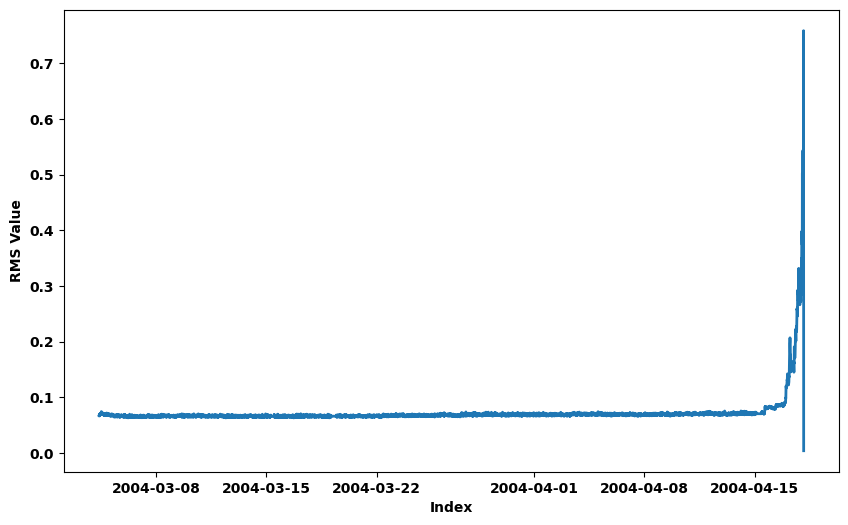

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is already defined
y = df['RMS'].values
X = np.asarray(df.index)

plt.figure(figsize=(10, 6))
plt.plot(X,y, linewidth=2)

# Add labels and title
plt.xlabel('Index', fontweight='bold')
plt.ylabel('RMS Value', fontweight='bold')


# Make tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')



# Show the plot
plt.show()


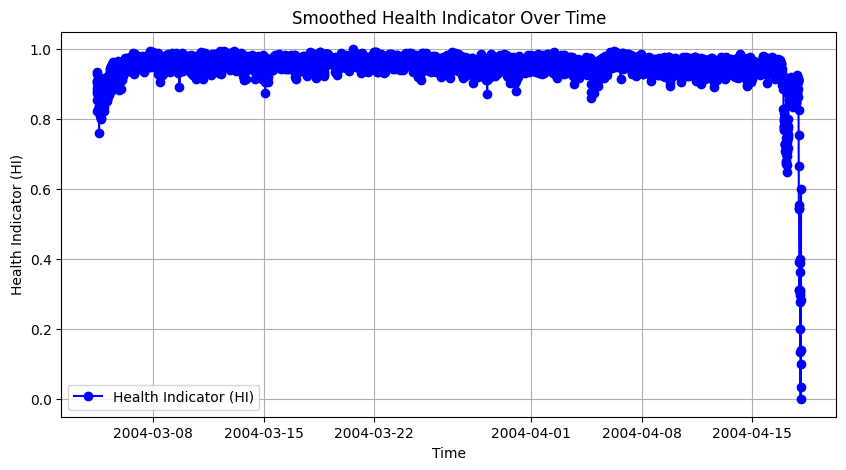

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def health(data, use_filter=True):
    bearing_data = data.copy()

    # Step 1: Extract only feature columns (ignore datetime index)
    feature_columns = ['RMS', 'Skewness', 'Kurtosis', 'Crest Factor',
                       'Shape Factor', 'Impulse Factor', 'Clearance Factor',
                       'Dominant Frequency', 'Mean Frequency', 'Median Frequency']

    feature_data = bearing_data[feature_columns]  # Extract vibration features

    # Step 2: Standardize features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(feature_data)

    # Step 3: Apply PCA (Extract First Principal Component)
    pca = PCA(n_components=1)
    health_indicator = pca.fit_transform(data_scaled).flatten()

    # Step 4: Smooth HI using EWMA (to prevent sudden drops)
    if use_filter:
        health_indicator = pd.Series(health_indicator).ewm(span=4, adjust=False).mean().values

    # Step 5: Normalize HI so that it starts at 1 and degrades to 0
    health_indicator = (health_indicator - np.min(health_indicator)) / (np.max(health_indicator) - np.min(health_indicator))
    health_indicator = 1- health_indicator  # Ensure HI starts at 1 and degrades smoothly

    # Step 6: Store HI as a new column in the original DataFrame
    bearing_data['label'] = health_indicator

    return bearing_data  # Returns dataframe with HI column added

df = health(df)

# Plot the Health Indicator Trend
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['label'], marker='o', linestyle='-', color='blue', label="Health Indicator (HI)")
plt.xlabel("Time")
plt.ylabel("Health Indicator (HI)")
plt.title("Smoothed Health Indicator Over Time")
plt.grid()
plt.legend()
plt.show()

In [ ]:
def normaliser(signal):
    signal_mean = np.mean(signal)
    signal_std = np.std(signal)
    return (signal - signal_mean) / signal_std
for col in df.columns:
    if col != 'label':
        df[col] = normaliser(np.asarray(df[col]))
df.head()

,RMS,Skewness,Kurtosis,Crest Factor,Shape Factor,Impulse Factor,Clearance Factor,Dominant Frequency,Mean Frequency,Median Frequency,label
2004-03-04 09:27:46,-0.195107,1.315968,1.095411,1.283382,1.953797,1.358103,1.413777,0.309527,0.214132,1.631501,0.888448
2004-03-04 09:32:46,-0.198508,0.044658,0.518748,-0.437168,1.067691,-0.365146,-0.325883,0.311380,1.402231,2.417199,0.908017
2004-03-04 09:42:46,-0.104177,0.705489,0.156018,-0.989120,0.338224,-0.935732,-0.914191,-1.119434,1.501002,1.808917,0.935742
2004-03-04 09:52:46,-0.122045,-0.126075,0.367931,0.668425,0.628406,0.677746,0.685592,-1.119434,1.027332,1.099254,0.929628
2004-03-04 10:02:46,-0.160014,0.400661,0.608180,1.829319,0.878305,1.814994,1.824719,0.313233,0.956848,1.631501,0.909324


In [ ]:
features = np.stack((df['RMS'],df['Skewness'],df['Kurtosis'],df['Crest Factor'],df['Shape Factor'],df['Impulse Factor'],df['Clearance Factor'],df['Dominant Frequency'],df['Mean Frequency'],df['Median Frequency']), axis=1)
X=features
y=np.asarray(df['label'])
print(f"LSTM Input Shape (X): {X.shape}")
print(f"RUL Labels Shape (y): {y.shape}")

LSTM Input Shape (X): (6324, 10)
RUL Labels Shape (y): (6324,)


In [ ]:
# Define sequence length (number of timesteps)
import numba
sequence_length = 3
@numba.jit(nopython=True)
def prepare_sequential_data(X, y, sequence_length):
    X_seq = np.empty((len(X) - sequence_length, sequence_length, X.shape[1]), dtype=X.dtype)
    y_seq = np.empty(len(X) - sequence_length, dtype=y.dtype)

    for i in range(len(X) - sequence_length):
        X_seq[i] = X[i:i + sequence_length]
        y_seq[i] = y[i + sequence_length - 1]
    return X_seq, y_seq
# Example Usage:
X_seq, y_seq = prepare_sequential_data(X, y, sequence_length)

In [ ]:
X_seq.shape

(6321, 3, 10)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X=torch.Tensor(X_seq)
y=torch.Tensor(y_seq)

# Create a TensorDataset
dataset = TensorDataset(X, y)
testloader = torch.utils.data.DataLoader(dataset, batch_size=32, drop_last=False,shuffle=False)

The MSE loss: 0.0116, The MAE loss: 0.0972


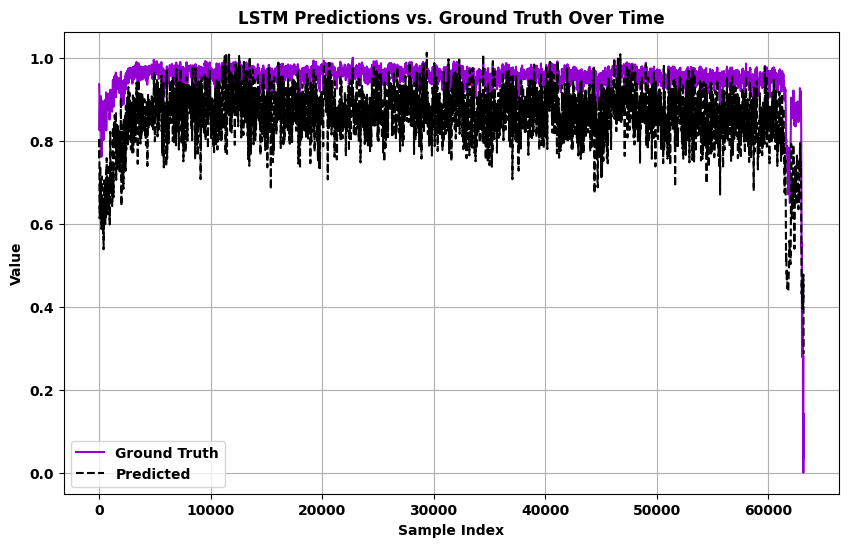

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Ensure model is in evaluation mode
model.eval()
for param in model.parameters():
    param.requires_grad = False

epoch_loss = 0
epoch_mae = 0
all_preds = []  # Store all predictions
all_targets = []  # Store all ground truth value

for batch_idx, (data, target) in enumerate(testloader):
    data, target = data.to(device), target.to(device)

    # Forward pass
    outputs = model(data)

    # Compute loss
    loss = F.mse_loss(outputs, target.unsqueeze(1))
    mae = F.l1_loss(outputs, target.unsqueeze(1))

    # Accumulate losses
    epoch_loss += loss.item()
    epoch_mae += mae.item()

    # Store values for plotting
    all_preds.extend(outputs.cpu().detach().numpy().flatten())
    all_targets.extend(target.cpu().numpy().flatten())

# Compute average loss
epoch_loss /= len(testloader)
epoch_mae /= len(testloader)

# Print loss values
print(f'The MSE loss: {epoch_loss:.4f}, The MAE loss: {epoch_mae:.4f}')

# Fix 2: Ensure no KeyError from index mismatch
X = np.arange(0, 10 * len(all_targets), 10)  # Assuming time step of 10

# Match length of X and predictions
min_len = min(len(X), len(all_targets), len(all_preds))
X = X[:min_len]
all_preds = all_preds[:min_len]
all_targets = all_targets[:min_len]

# Plot Ground Truth and Predictions Over Time
plt.figure(figsize=(10, 6))
plt.plot(X, all_targets, label="Ground Truth", color='darkviolet')
plt.plot(X, all_preds, label="Predicted", color='black', linestyle='dashed')

# Set bold font for title and labels
plt.title("LSTM Predictions vs. Ground Truth Over Time", fontweight='bold')
plt.xlabel("Sample Index", fontweight='bold')
plt.ylabel("Value", fontweight='bold')

# Set bold font for tick values
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Legend formatting
plt.legend(fontsize='medium', loc='best', frameon=True)
leg = plt.gca().get_legend()
for text in leg.get_texts():
    text.set_fontweight('bold')

plt.grid()


# Show the plot
plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft

def compute_statistical_features(signal):
    rms = np.sqrt(np.mean(signal**2))
    skewness = skew(signal)
    kurt = kurtosis(signal)
    crest_factor = np.max(np.abs(signal)) / rms
    shape_factor = rms / np.mean(np.abs(signal))
    impulse_factor = np.max(np.abs(signal)) / np.mean(np.abs(signal))
    clearance_factor = np.max(np.abs(signal)) / (np.mean(np.sqrt(np.abs(signal)))**2)
    return [rms, skewness, kurt, crest_factor, shape_factor, impulse_factor, clearance_factor]

def compute_frequency_features(signal, sampling_rate=20480):
    signal = signal - np.mean(signal)  # Remove DC component
    N = len(signal)  # Number of points
    fft_values = fft(signal.values)[:N//2]
    amplitudes = np.abs(fft_values) / N
    frequencies = np.linspace(0, sampling_rate / 2, N//2)

    # Extract meaningful frequency features
    dominant_freq = frequencies[np.argmax(amplitudes)]
    mean_freq = np.sum(frequencies * amplitudes) / np.sum(amplitudes)
    median_freq = frequencies[np.searchsorted(np.cumsum(amplitudes), np.sum(amplitudes) / 2)]

    return [dominant_freq, mean_freq, median_freq]
data_dir = '/content/4th_test/txt'

# Initialize DataFrame
df = pd.DataFrame()
counter =0
# Process each file
for filename in os.listdir(data_dir):
    #if(counter==4448):
     #   break
    file_path = os.path.join(data_dir, filename)
    dataset = pd.read_csv(file_path, sep='\t', header=None)
    #signal = dataset.iloc[:, [0, 1]].mean(axis=1)
    signal=dataset.iloc[:,0]
    counter+=1

    # Compute features
    stat_features = compute_statistical_features(signal)
    freq_features = compute_frequency_features(signal, sampling_rate=20480)

    # Combine all features
    all_features = stat_features + freq_features

    # Create DataFrame for the current file
    feature_df = pd.DataFrame([all_features], columns=[
        "RMS", "Skewness", "Kurtosis", "Crest Factor",
        "Shape Factor", "Impulse Factor", "Clearance Factor",
        "Dominant Frequency", "Mean Frequency", "Median Frequency"
    ])
    timestamp = pd.to_datetime(filename, format='%Y.%m.%d.%H.%M.%S')
    feature_df.index = [timestamp]

    df = pd.concat([df, feature_df])
df = df.sort_index()
(df.head())

,RMS,Skewness,Kurtosis,Crest Factor,Shape Factor,Impulse Factor,Clearance Factor,Dominant Frequency,Mean Frequency,Median Frequency
2004-03-04 09:27:46,0.079768,0.030877,1.292720,7.133162,1.294337,9.232717,11.085369,1008.098447,3909.184273,3730.364293
2004-03-04 09:32:46,0.078678,-0.013807,1.157037,6.240622,1.294551,8.078805,9.700083,1009.098545,4062.666253,3872.378162
2004-03-04 09:42:46,0.079815,0.033420,0.890123,6.452419,1.283364,8.280802,9.898509,1009.098545,4079.709733,3883.379236
2004-03-04 09:52:46,0.081082,-0.027040,1.181861,6.807885,1.287191,8.763046,10.475032,1009.098545,4015.427741,3840.375037
2004-03-04 10:02:46,0.079165,-0.017775,0.585798,4.812731,1.277999,6.150664,7.341759,1010.098642,4044.381118,3868.377771


In [ ]:
def normaliser(signal):
    signal_mean = np.mean(signal)
    signal_std = np.std(signal)
    return (signal - signal_mean) / signal_std
for col in df.columns:
    if col != 'label':
        df[col] = normaliser(np.asarray(df[col]))
df.head()

,RMS,Skewness,Kurtosis,Crest Factor,Shape Factor,Impulse Factor,Clearance Factor,Dominant Frequency,Mean Frequency,Median Frequency
2004-03-04 09:27:46,0.859396,0.257691,4.784744,2.250131,3.947405,2.387984,2.452377,-0.021391,-4.965532,-3.610191
2004-03-04 09:32:46,0.692098,-0.989877,4.030532,1.079920,3.980582,1.218878,1.282157,-0.011729,-0.879230,-1.021918
2004-03-04 09:42:46,0.866571,0.328686,2.546860,1.357607,2.245708,1.423536,1.449778,-0.011729,-0.425465,-0.821418
2004-03-04 09:52:46,1.061061,-1.359357,4.168521,1.823660,2.839112,1.912129,1.936796,-0.011729,-2.136907,-1.605191
2004-03-04 10:02:46,0.766826,-1.100684,0.855232,-0.792189,1.413651,-0.734650,-0.710037,-0.002067,-1.366053,-1.094827


In [ ]:
features = np.stack((df['RMS'],df['Skewness'],df['Kurtosis'],df['Crest Factor'],df['Shape Factor'],df['Impulse Factor'],df['Clearance Factor'],df['Dominant Frequency'],df['Mean Frequency'],df['Median Frequency']), axis=1)
X=features
print(f"LSTM Input Shape (X): {X.shape}")

LSTM Input Shape (X): (6324, 10)


In [ ]:
# Define sequence length (number of timesteps)
import numba
sequence_length = 3
@numba.jit(nopython=True)
def prepare_sequential_data(X, sequence_length):
    X_seq = np.empty((len(X) - sequence_length, sequence_length, X.shape[1]), dtype=X.dtype)
    for i in range(len(X) - sequence_length):
        X_seq[i] = X[i:i + sequence_length]
    return X_seq
# Example Usage:
X_seq = prepare_sequential_data(X, sequence_length)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X=torch.Tensor(X_seq)

# Create a TensorDataset
dataset = TensorDataset(X)
testloader = torch.utils.data.DataLoader(dataset, batch_size=32, drop_last=False,shuffle=False)

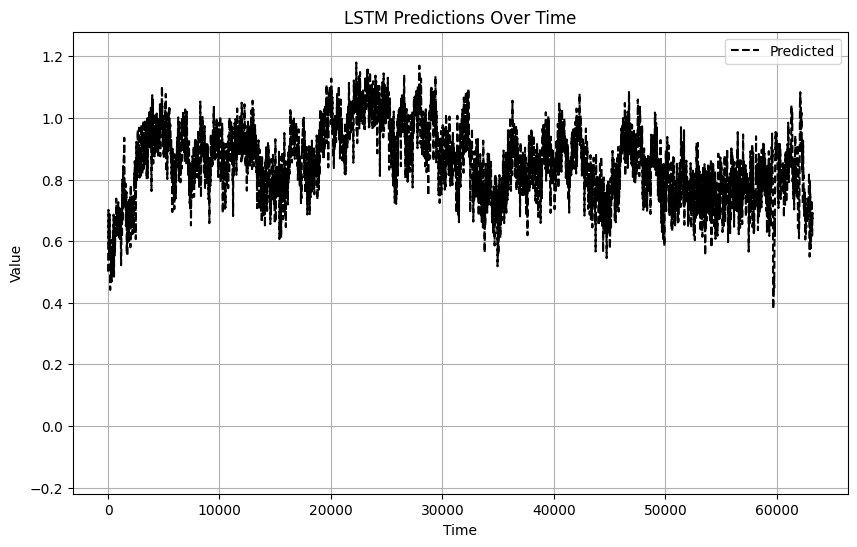

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Ensure model is in evaluation mode
model.eval()
for param in model.parameters():
    param.requires_grad = False

all_preds = []  # Store all predictions

# Loop through the test DataLoader
for batch_idx, (data,) in enumerate(testloader):  # Single tensor (data,)
    data = data.to(device)

    # Forward pass
    outputs = model(data)

    # Store predictions
    all_preds.extend(outputs.cpu().detach().numpy().flatten())

# Generate time axis for plotting
X = np.arange(0, 10 * len(all_preds), 10)  # Time steps, assuming step size of 10

# Plot Predictions Over Time with adjusted Y-axis
plt.figure(figsize=(10, 6))
plt.plot(X, all_preds, label="Predicted", color='black', linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("LSTM Predictions Over Time")
plt.legend()
plt.grid()

# Adjust the Y-axis limits to show the full range
plt.ylim(min(all_preds) - 0.6, max(all_preds)+.1)  # Add margin to ensure visibility

plt.show()